In [134]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from itertools import combinations, islice
from scipy import stats
from collections import defaultdict, Counter
from multiprocessing import Pool

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing

from news_vec.corpus import Corpus
from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
class Actors:
    
    def __init__(self, root, skim=None):
        self.root = root
        self.skim = skim
        
    def __iter__(self):
        reader = islice(read_json_gz_lines(self.root), self.skim)
        yield from tqdm(reader)

In [17]:
actors = Actors('../data/clf-actors.json/')

In [18]:
next(iter(actors))

0it [00:00, ?it/s]


{'actor_id': 'id:twitter.com:2793391472',
 'article_id': 37255,
 'domain': 'apnews.com',
 'ts_bucket': 7}

In [19]:
ACTOR_DOMAIN_COUNTS = defaultdict(Counter)
ARTICLE_ACTORS = defaultdict(set)

for r in actors:
    ACTOR_DOMAIN_COUNTS[r['actor_id']][r['domain']] += 1
    ARTICLE_ACTORS[r['article_id']].add(r['actor_id'])

76224508it [07:41, 165279.92it/s]


In [20]:
len(ACTOR_DOMAIN_COUNTS)

8444480

In [21]:
ACTOR_DOMAIN_DISTS = {}

for aid, counts in tqdm(ACTOR_DOMAIN_COUNTS.items()):
    total = sum(counts.values())
    dist = dict([(d, count / total) for d, count in counts.items()])
    ACTOR_DOMAIN_DISTS[aid] = dist

100%|██████████| 8444480/8444480 [00:41<00:00, 204876.00it/s]


In [22]:
ACTOR_DOMAIN_DISTS['id:twitter.com:2793391472']

{'apnews.com': 0.49585406301824214,
 'npr.org': 0.03648424543946932,
 'cnn.com': 0.05472636815920398,
 'dailykos.com': 0.01658374792703151,
 'nytimes.com': 0.12106135986733002,
 'huffingtonpost.com': 0.03648424543946932,
 'washingtonpost.com': 0.1077943615257048,
 'foxnews.com': 0.004975124378109453,
 'thehill.com': 0.0812603648424544,
 'buzzfeed.com': 0.011608623548922056,
 'wsj.com': 0.014925373134328358,
 'bloomberg.com': 0.01824212271973466}

In [23]:
ARTICLE_ACTORS[3378]

{'id:twitter.com:1069174837',
 'id:twitter.com:124814437',
 'id:twitter.com:1905590958',
 'id:twitter.com:191162512',
 'id:twitter.com:22438091',
 'id:twitter.com:256184059',
 'id:twitter.com:28645214',
 'id:twitter.com:3080050650',
 'id:twitter.com:3090358105',
 'id:twitter.com:354537587',
 'id:twitter.com:55618046',
 'id:twitter.com:747144457741606912',
 'id:twitter.com:838526550660296704',
 'id:twitter.com:849723351715139584',
 'id:twitter.com:851305143933046785'}

In [24]:
def article_mean_actor_domain_pct(article_id, domain):
    actors = ARTICLE_ACTORS[article_id]
    pcts = [ACTOR_DOMAIN_DISTS[aid].get(domain, 0) for aid in actors]
    return np.mean(pcts)

In [26]:
article_mean_actor_domain_pct(3378, 'foxnews.com')

0.18167772698894957

In [31]:
corpus = Corpus('../data/clf-headlines.json/')

2018-12-29 17:00:41,442 | INFO : Reading headlines.
1225511it [01:25, 14306.53it/s]


In [32]:
def pred_ab(d1, d2):
    
    df = corpus.sample_ab(d1, d2)

    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )

    df_train, df_test = train_test_split(df)

    X_train = tv.fit_transform(df_train.clf_tokens)
    X_test = tv.transform(df_test.clf_tokens)

    clf = LogisticRegression(solver='lbfgs')
    fit = clf.fit(X_train, df_train.domain)

    df_test = df_test.copy()
    
    df_test['p_true'] = [
        p[0] if d==fit.classes_[0] else p[1]
        for p, d in zip(fit.predict_proba(X_test), df_test.domain)
    ]
    
    df_test['p_false'] = 1 - df_test.p_true
    
    df_test['b_domain'] = df_test.domain.apply(lambda d: d1 if d==d2 else d2)
    df_test['b_actor_pct'] = df_test.apply(lambda r: article_mean_actor_domain_pct(r.article_id, r.b_domain), 1)
    df_test['b_actor_pct_scaled'] = preprocessing.scale(df_test.b_actor_pct)
    
    return df_test

In [94]:
def pf_bpct_corr(pred_df, domain):
    df = pred_df[pred_df.domain==domain].copy()
    corr, p = stats.kendalltau(df.p_false, df.b_actor_pct)
    return corr, p, df

In [116]:
def plot_sl_audience(d1, d2, max_pct_rank=0.95):
    
    pred_df = pred_ab(d1, d2)
    corr, p, ddf = pf_bpct_corr(pred_df, d1)
    
    plt.figure(figsize=(10,5))
    
    print(corr, p)
    
    sns.jointplot(
        y='b_actor_pct',
        x='p_false',
        data=ddf[ddf.b_actor_pct.rank(pct=True) < max_pct_rank],
        height=10,
        kind='reg',
        scatter_kws=dict(s=1),
    )
    
    plt.show()
    
    return pred_df

0.31407505150331055 0.0


<Figure size 720x360 with 0 Axes>

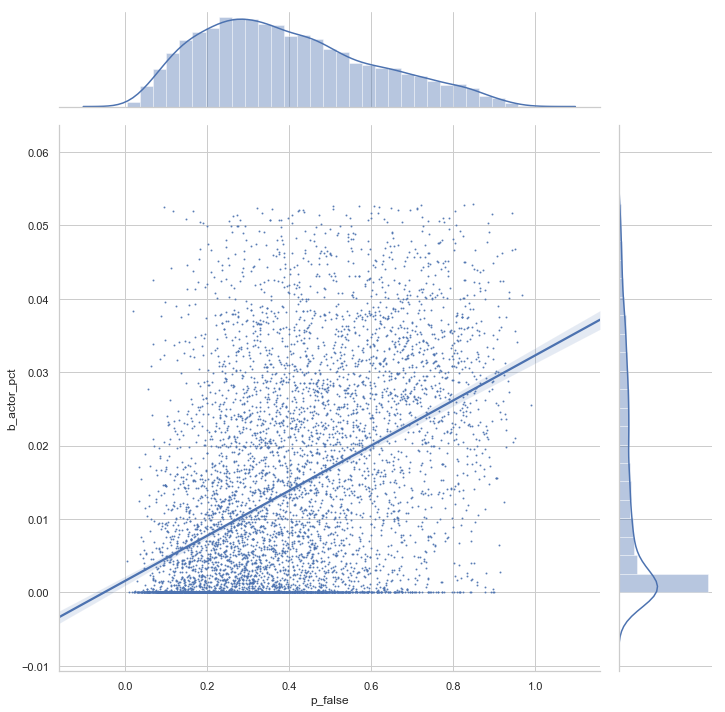

In [117]:
_ = plot_sl_audience('huffingtonpost.com', 'dailykos.com')

-0.0015090271126962523 0.851937026709691


<Figure size 720x360 with 0 Axes>

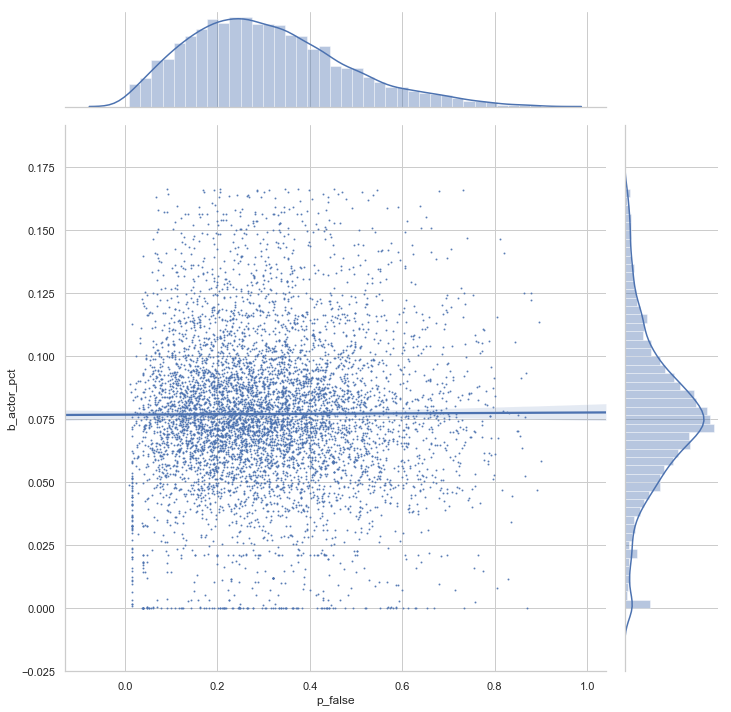

In [118]:
_ = plot_sl_audience('dailykos.com', 'huffingtonpost.com')

-0.06900431957901107 3.1934739977977566e-17


<Figure size 720x360 with 0 Axes>

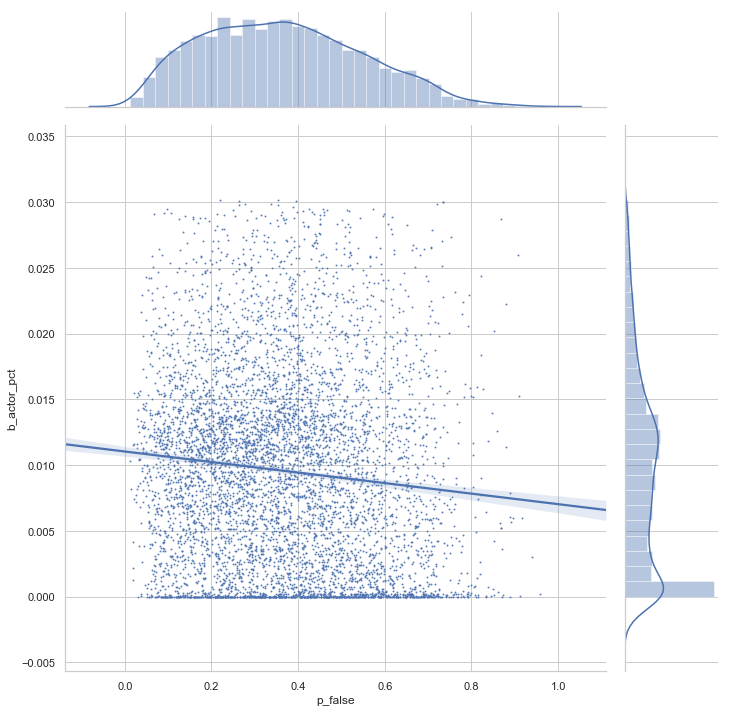

In [119]:
_ = plot_sl_audience('foxnews.com', 'apnews.com')

-0.013022716035557488 0.11111757007395384


<Figure size 720x360 with 0 Axes>

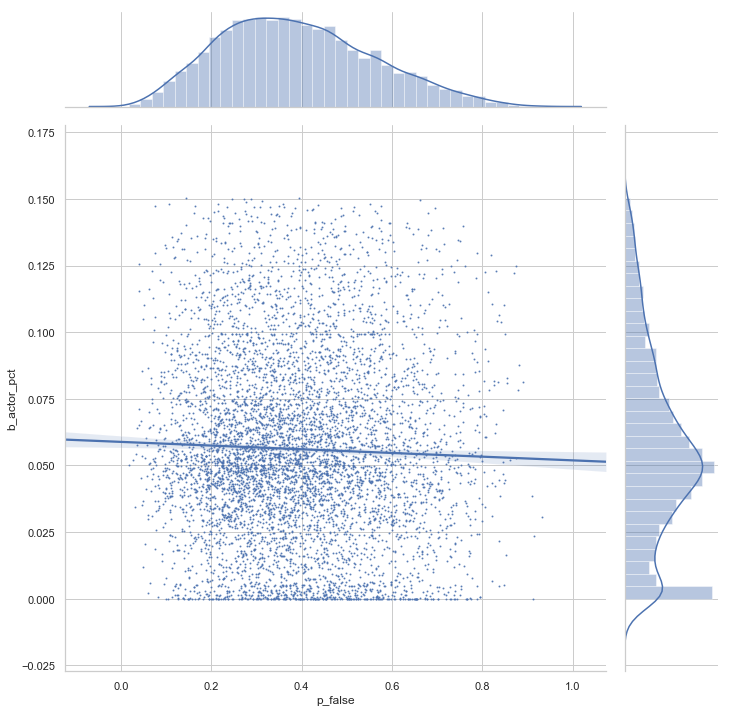

In [120]:
_ = plot_sl_audience('foxnews.com', 'cnn.com')

0.07391516129830854 8.705009727884385e-20


<Figure size 720x360 with 0 Axes>

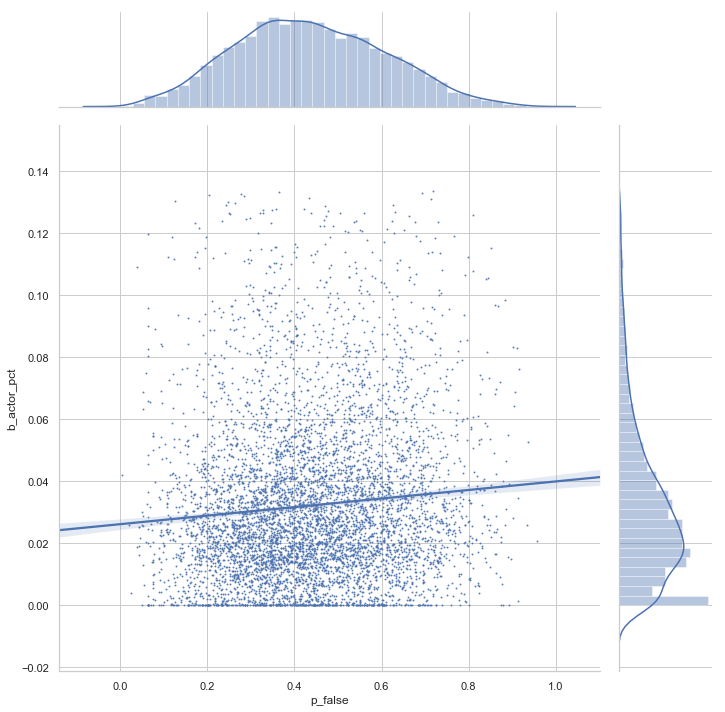

In [121]:
_ = plot_sl_audience('cnn.com', 'foxnews.com')

0.05695298590203733 3.293237690034994e-12


<Figure size 720x360 with 0 Axes>

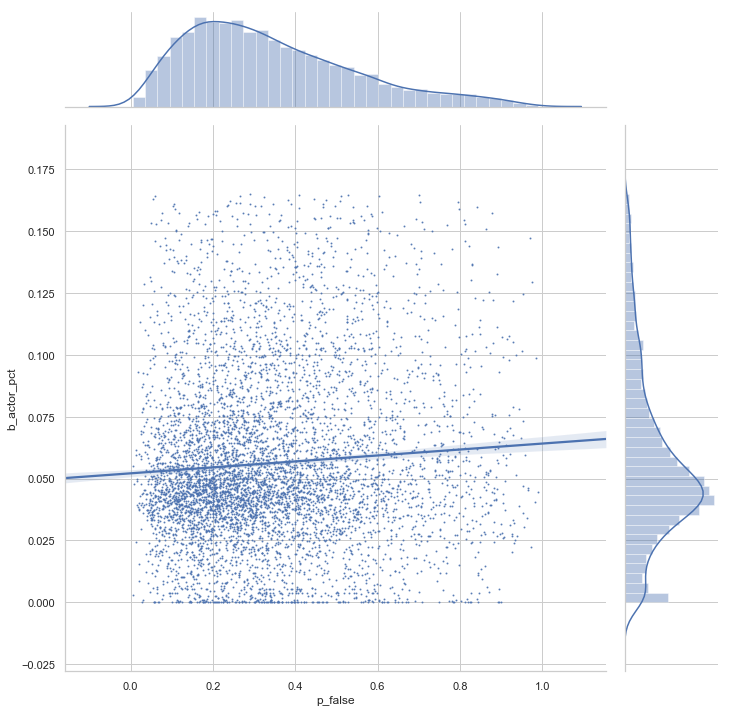

In [122]:
_ = plot_sl_audience('foxnews.com', 'nytimes.com')

0.09084108020708904 1.0989929257103621e-28


<Figure size 720x360 with 0 Axes>

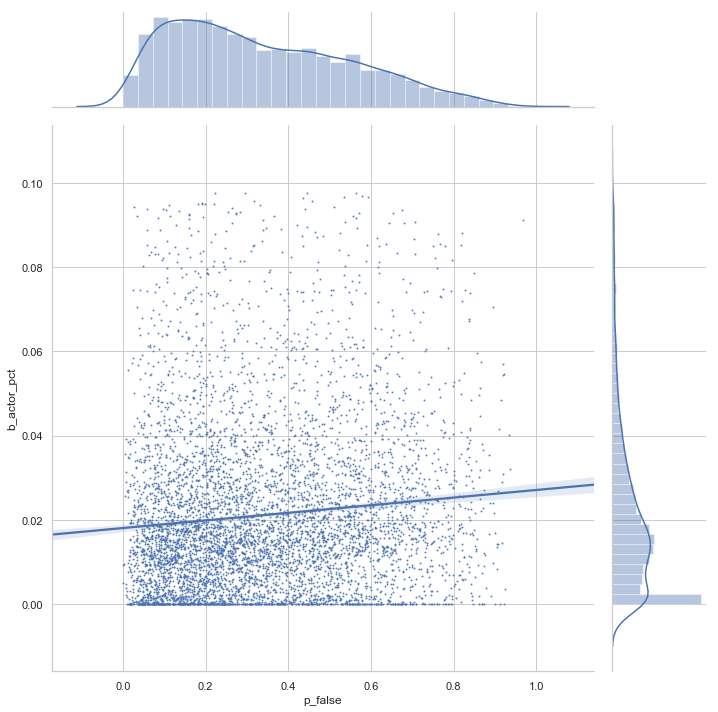

In [123]:
_ = plot_sl_audience('nytimes.com', 'foxnews.com')

0.05500144869418193 1.6624360675836116e-11


<Figure size 720x360 with 0 Axes>

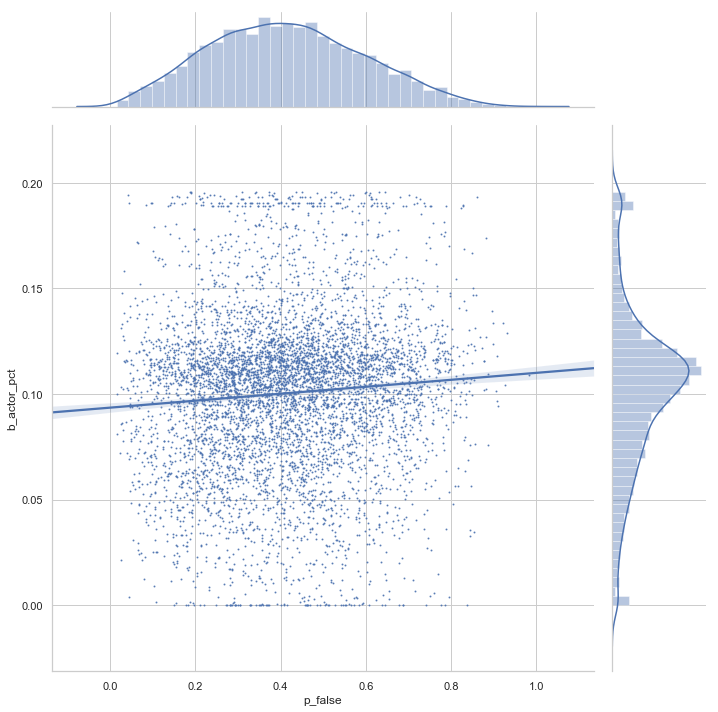

In [124]:
_ = plot_sl_audience('breitbart.com', 'dailycaller.com')

-0.011750892887284505 0.1480966661090059


<Figure size 720x360 with 0 Axes>

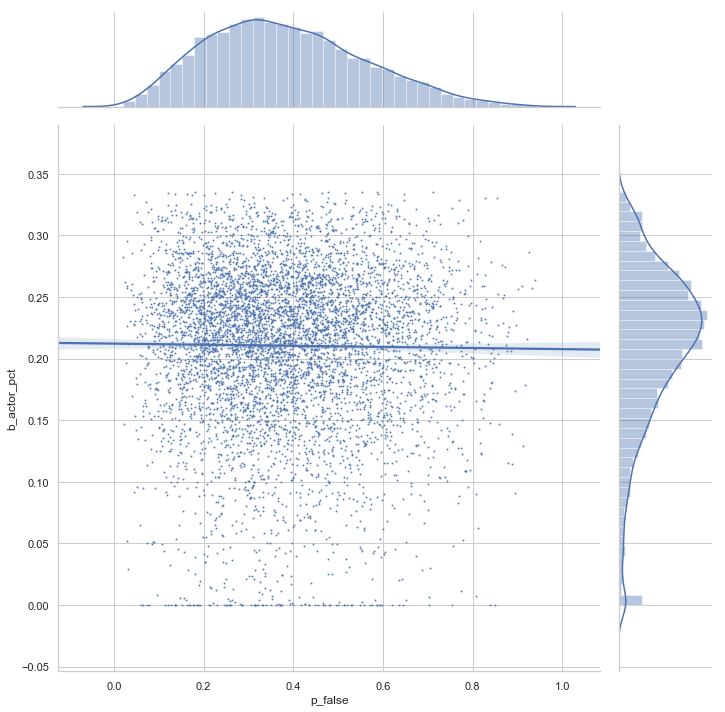

In [125]:
_ = plot_sl_audience('dailycaller.com', 'breitbart.com')

0.36502188284470116 0.0


<Figure size 720x360 with 0 Axes>

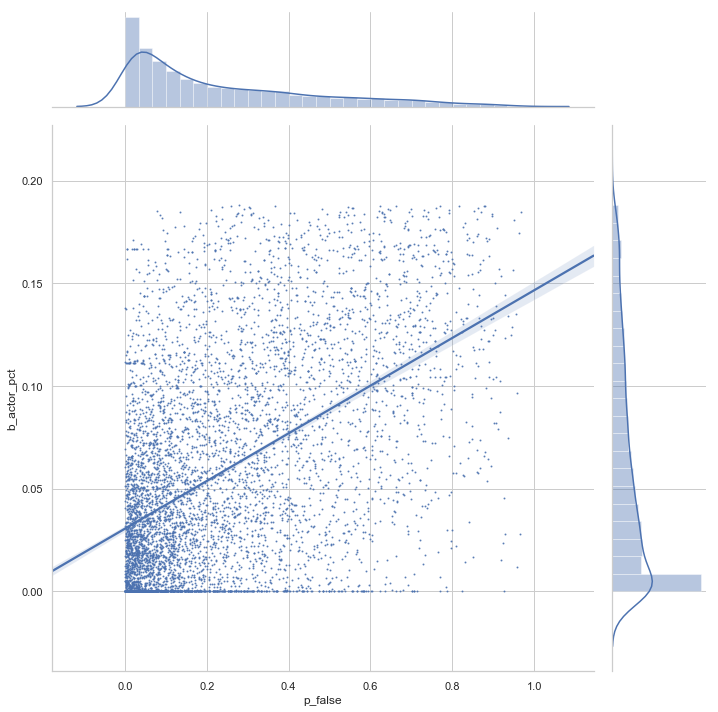

In [126]:
_ = plot_sl_audience('buzzfeed.com', 'washingtonpost.com')

0.2792909133983575 8.180448567922964e-256


<Figure size 720x360 with 0 Axes>

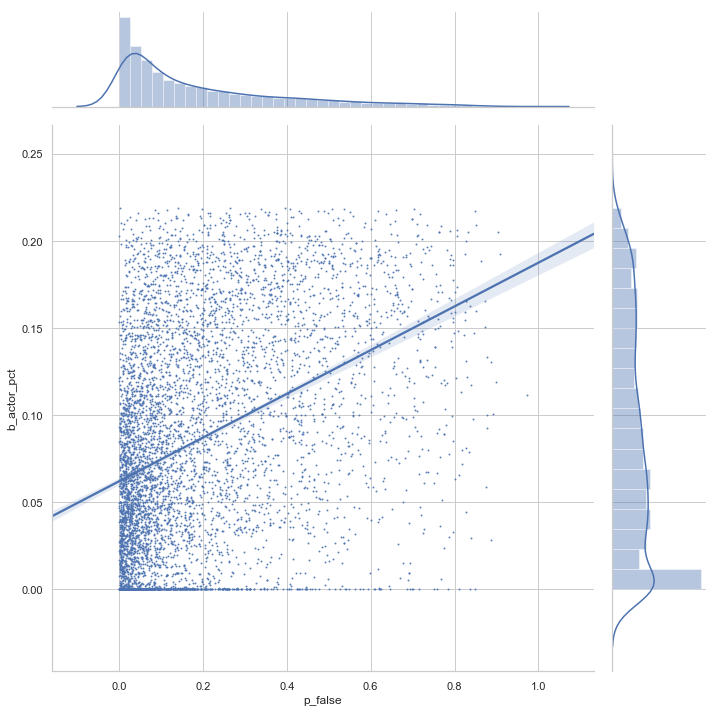

In [127]:
_ = plot_sl_audience('buzzfeed.com', 'nytimes.com')

-0.06900336495882173 1.696568634348411e-17


<Figure size 720x360 with 0 Axes>

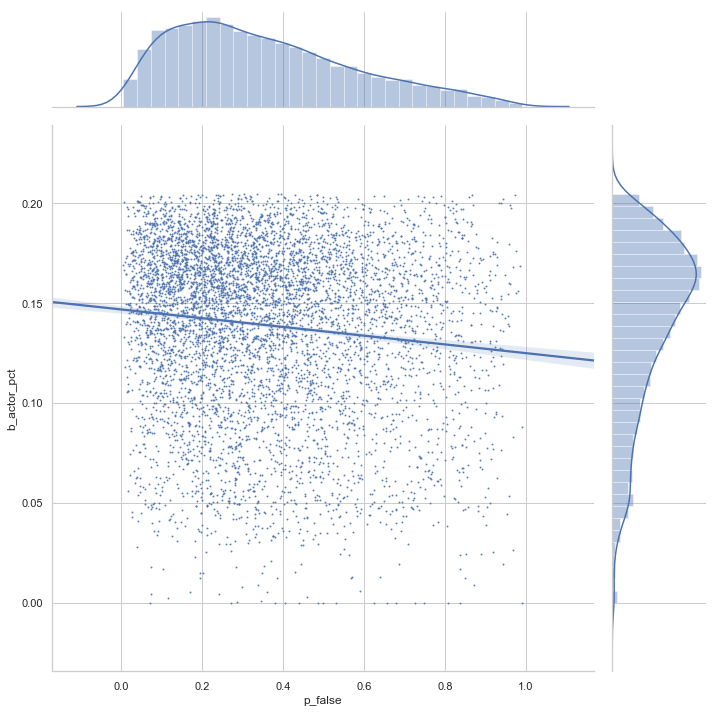

In [128]:
_ = plot_sl_audience('thehill.com', 'washingtonpost.com')

0.15412690778976443 9.339381747553766e-79


<Figure size 720x360 with 0 Axes>

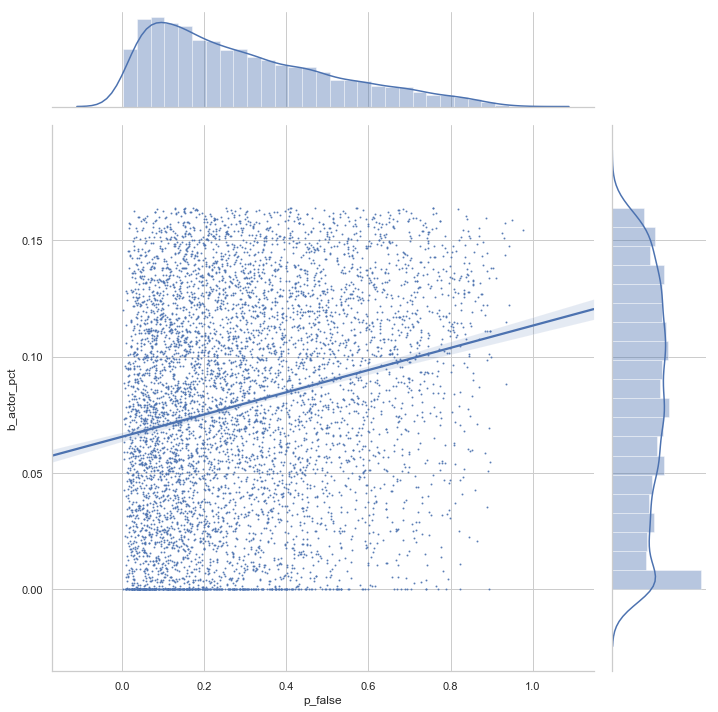

In [129]:
_ = plot_sl_audience('washingtonpost.com', 'thehill.com')

-0.06889123409621545 1.7337589022719357e-17


<Figure size 720x360 with 0 Axes>

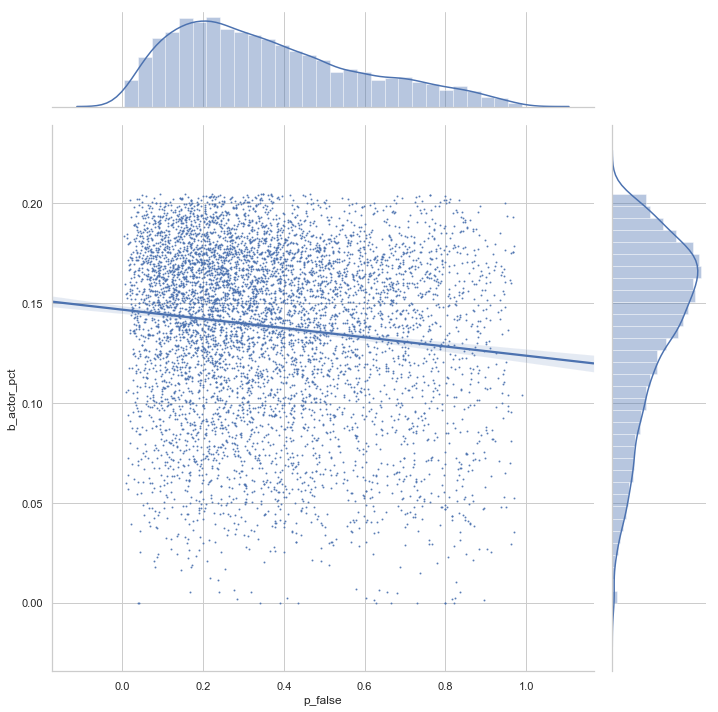

In [130]:
_ = plot_sl_audience('thehill.com', 'washingtonpost.com')

In [131]:
domains = corpus.df.domain.unique()

In [132]:
pairs = list(combinations(domains, 2))

In [ ]:
rows = []
for d1, d2 in tqdm(pairs):
    
    pred_df = pred_ab(d1, d2)
    
    corr1, p1, corr1_df = pf_bpct_corr(pred_df, d1)
    corr2, p2, corr2_df = pf_bpct_corr(pred_df, d2)
    
    rows.append((d1, d2, corr1, p1, corr1_df.b_actor_pct.mean()))
    rows.append((d2, d1, corr2, p2, corr2_df.b_actor_pct.mean()))


  3%|▎         | 4/120 [01:28<43:29, 22.50s/it]/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

 28%|██▊       | 33/120 [14:42<1:00:40, 41.85s/it]

In [142]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p', 'mean_b_actor_pct'))

In [143]:
df['label'] = df.apply(lambda r: f'{r.d1} -> {r.d2}', 1)

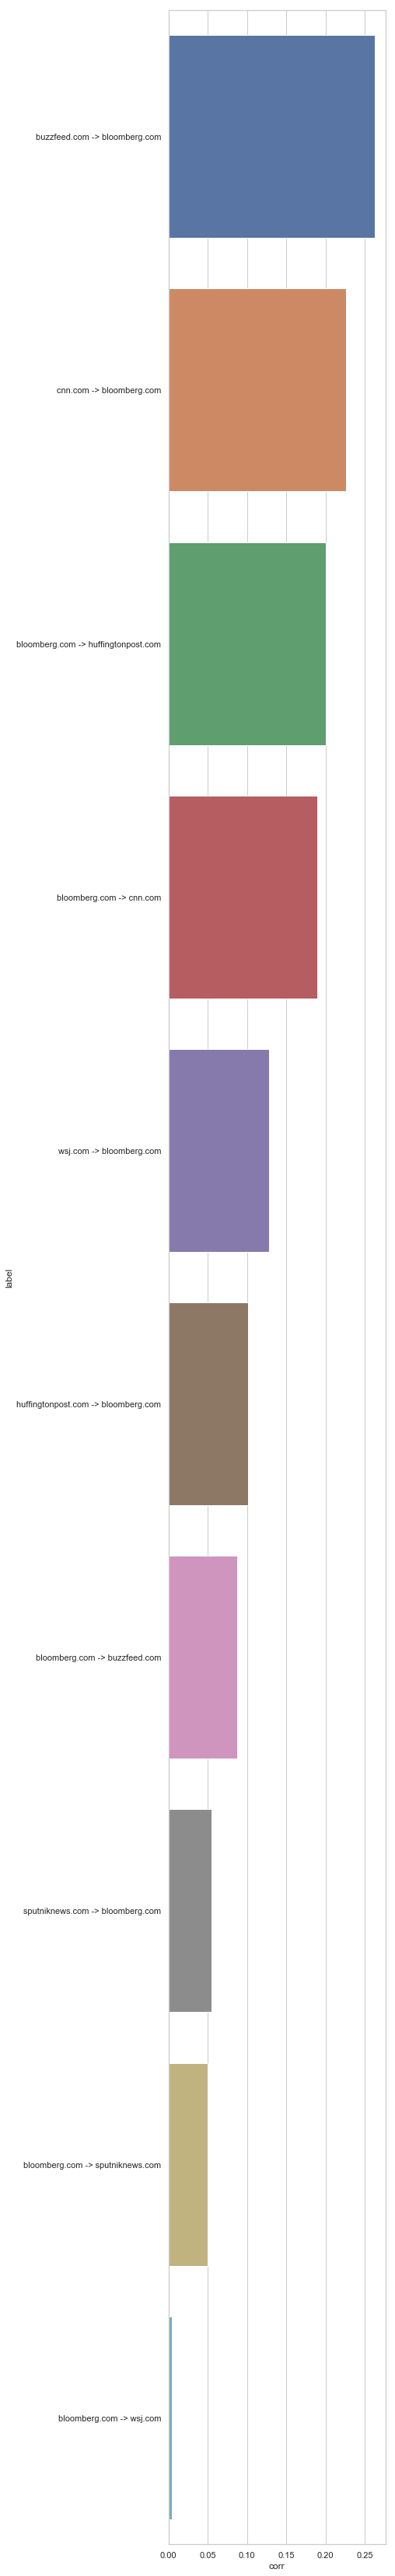

In [88]:
plt.figure(figsize=(5,60))
sns.barplot(x='corr', y='label', data=df.sort_values('corr', ascending=False))